<a href="https://colab.research.google.com/github/NganTran-0017/LING5412/blob/main/GPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DEEP LEARNING MODELS - PART 3:**
**Description**
GPT is a transformer-based model that is created by OpenAI in 2019. Similar to BERT, GPT uses attention mechanism to learn context and the most important words in a sentence. The main difference between these 2 models is that GPT is unidirectional, while BERT is bidirectional. However, both models have comparable performances. As GPT was pre-trained on 8 million web pages, it only needs a small dataset to finetune and perform specific tasks like detecting patronizing and condescending language. Therefore, we select GPT-2 for this project with a hope that it can outperform traditional ML models and generates high performance. 

This notebook load and process text data, and then partition it into training and testing sets. Next, we start processing text data with GPT pretrained tokenizer and embedding words in each training instance into numeric. Since this data is very imbalance, we add an upsampling option to see if the model can improve its performance. If upsampling option is checked above, we'll upsample the training set using SMOTE. 

Mask paddings are added to the processed training data and then we start finetuning the pretrained GPT model in 3 epochs and 32 batch size. Once the training is completed, we evaluate the model performance on the testing data, annd print the model performance. We also save GPT performance in a text file, whose name indicates whether the data was upsampled or not. This way, we can compare it against the rest of the models in the Visualization notebook. 

In [ ]:
#@title Specifying Upsampling Option
UPSAMPLE = True #@param {type:"boolean"}


In [ ]:
from torch import nn
from keras.preprocessing.sequence import pad_sequences
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output

In [ ]:
import tarfile
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix, recall_score
# from sklearn.model_selection import cross_validate
# from sklearn.model_selection import KFold
# from sklearn.model_selection import StratifiedKFold
!pip install imbalanced-learn
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score, roc_auc_score

# **Loading data**

Connects google drive to this notebook to get the dataset, and then unzip it. Then, we load the specified columns (docID, keyword, country, paragraph and label) into the df.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Unzip the dataset
!unzip "/content/drive/MyDrive/dontpatrAAonizeme_v1.3.zip" -d "/content/drive/MyDrive/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
unzip:  cannot find or open /content/drive/MyDrive/dontpatrAAonizeme_v1.3.zip, /content/drive/MyDrive/dontpatrAAonizeme_v1.3.zip.zip or /content/drive/MyDrive/dontpatrAAonizeme_v1.3.zip.ZIP.


In [ ]:
# Opening the file from MyDrive
file = open(r'/content/drive/MyDrive/dontpatronizeme_v1.3/dontpatronizeme_pcl.tsv')
reader = csv.reader(file, delimiter="\t")
data = []
for row in reader:
  data.append(row)

In [ ]:
# Create a df using the specified columns
df = pd.DataFrame(data[5:],  columns = ['docID', 'keyword', 'country', 'paragraph', 'label' ] )
df

,docID,keyword,country,paragraph,label
0,@@4703096,immigrant,jm,NBC and Spanish-language Univision both declin...,0
1,@@25567226,in-need,hk,A second T-Home project is being launched in t...,0
2,@@1824078,poor-families,tz,Camfed would like to see this trend reversed ....,4
3,@@1921089,refugee,tz,Kagunga village was reported to lack necessary...,0
4,@@40039380,women,ng,Haruna stressed the need for specific approach...,0
...,...,...,...,...,...
10053,@@16413808,immigrant,my,"To me , I am always mindful that we are dealin...",4
10054,@@8676630,vulnerable,jm,Other themes included promoting the inclusion ...,0
10055,@@7688552,immigrant,gb,It came as the CDU was also humiliated by the ...,0
10056,@@4916290,hopeless,in,"Those were only days of helplessness , she say...",0


# **Exploring data**

Get the length of each data instance and plot its histogram.

In [ ]:
# Length of text
def length (txt):
  length = len(txt.split())
  return length

txt_length = df['paragraph'].apply(lambda x: length(x))
txt_length.sort_values(ascending = False)

3534    1519
6266    1095
8519    1040
4613     772
8819     729
        ... 
1930       4
1385       3
7375       3
5112       3
5742       0
Name: paragraph, Length: 10058, dtype: int64

None of the column contains missing values.

In [ ]:
#checking for missing values
print('Is null: \n', df.isnull().sum() )

Is null: 
 docID        0
keyword      0
country      0
paragraph    0
label        0
dtype: int64


There are 5 labels in this dataset. The label number represents the degree of patronizing and condescending language (PCL).  Label 0 are sentences that do not contain patronizing nor condescending language, where as Label 4 are sentences with highly PCL. Based on the value counts below, the majority of data is negative with a label 0, whereas only 946 records are positive. Positive data contain labels from 1 to 4.

In this project, we choose task 1 that is a binary classification of PCL. Therefore, we convert the labels into 0 and 1, where 0 means negative and 1 means positive. The negative data contain label 0 originally, and the positive data contain labels 1 to 4.

0    9112
1     946
Name: label, dtype: int64


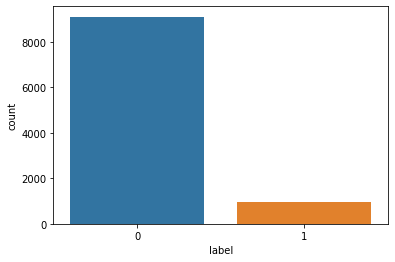

In [ ]:
# Convert label data type to string
df['label'] = df['label'].astype(str)
df['label']

# One hot encoding labels
label_dic = {'0':0,
             '1':0,
             '2':1,
             '3':1,
             '4':1}
df['label'] = df['label'].map(label_dic)
print(df['label'].value_counts())
sns.countplot(x='label', data=df)
plt.show()

# **Data Partition**

Once the data is thoroughly explored, we proceed to partition the shuffled data into training and testing sets with a ratio of 80-20. 

In [ ]:
# Splitting the data into training (80%) and test set(20%)
from sklearn.model_selection import train_test_split
X = df['paragraph']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split (X, y, train_size = 0.8, random_state = 42, shuffle = True, stratify=y)
print ('Shapes of X_train, y_train: ', X_train.shape, y_train.shape)
print ('Shapes of X_test, y_test: ', X_test.shape, y_test.shape)
print(y_train.value_counts())

Shapes of X_train, y_train:  (8046,) (8046,)
Shapes of X_test, y_test:  (2012,) (2012,)
0    7289
1     757
Name: label, dtype: int64


# **Create helper functions for printing and recording performance measures**

This part creates 2 helper function, where printing_eval_scores is responsible for printing out the model performance and get_roc_curve is responsible for extracting different metrics such as false positive rate (FPR), recall, macro-f1 scores and auc score. These 2 functions take the ground truth labels and predicted labels as inputs.

Since the data is very imbalanced, we decide to use macro-F1 score as a standard metric to compare among the candidate models. Macro-F1 score takes both major class and minor class into account regardless of their sizes. Therefore, using this metric will give us a more precise baseline to compare among the models. 

In [ ]:
# Printing model performance 
def printing_eval_scores (y_true, y_pred):
  print('accuracy score: {}'.format(sklearn.metrics.accuracy_score(y_true, y_pred)))
  print('precision score: {}'.format(sklearn.metrics.precision_score(y_true, y_pred, average = 'macro', zero_division=1)))
  print('recall score: {}'.format(sklearn.metrics.recall_score(y_true, y_pred,  average = 'macro', zero_division=1)))
  print('F1 score: {}'.format(f1_score(y_true, y_pred,  average = 'macro', zero_division=1)))
  print('\nConfusion Matrix:\n', confusion_matrix(y_true, y_pred))
  print('\n', classification_report(y_true, y_pred))

# Get the measurements of ROC curve for each model
def get_roc_cuve (y_true, y_pred):
  # Get arrays of FPR and recall using roc_curve
  FPR, recall, threshold = sklearn.metrics.roc_curve(y_true, y_pred)

  # Get testing accuracy:
  acc = accuracy_score( y_test,y_pred)

  # Get testing macro-f1:
  f1 = f1_score(y_test, y_pred,  average = 'macro', zero_division=1)

  # Get auc score
  auc = sklearn.metrics.auc(FPR, recall)
  roc = {'fpr': FPR, 'tpr': recall, 'auc': auc, 'accuracy': acc, 'macro-F1': f1}
  return roc

# **GPT-2**

**Get maximum length of a sentence**

 If it's greater than 512, MAX_LEN is set to be 225. We tried to set it with 512, but we run out of GPU memory, so we decide to set it as 225.

In [ ]:
# get max len in tokenized train text to set the tokens length in the next step
MAX_LEN = max(map(len, X_train))  # 
print('MAX LEN of trainning sentence is:', MAX_LEN, '\nMAX LEN > 512 is ', MAX_LEN>512)

# Update MAX LEN if it's > 512, set it to be 225 
## 512 is is the maximum seq len of BERT_BASE. But we cannot allow the seq len to be 512 since we'll run out of GPU memory --> Use max len of 225
MAX_LEN = 225 if MAX_LEN > 512 else MAX_LEN

MAX LEN of trainning sentence is: 8779 
MAX LEN > 512 is  True


In [ ]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
!pip install transformers

from transformers import GPT2Tokenizer, GPT2ForSequenceClassification

# Load GPT2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('microsoft/DialoGPT-small')

Since we use a MAX_LEN of 225, some sentences will be shorter than that. Therefore, we need to embed its empty space on the right after tokenizing the data.

In [ ]:
# Padding sequences from the right to MAX_LEN (225) and tokenize train set
tokenizer.padding_side = "right"
tokenizer.pad_token = tokenizer.eos_token
train_tokens = tokenizer(X_train.to_list(), return_tensors='pt', truncation=True, padding=True, max_length = MAX_LEN)
test_tokens  = tokenizer(X_test.to_list(),  return_tensors='pt', truncation=True, padding=True, max_length = MAX_LEN)

In [ ]:
# This is the embedded word vector of each training instance
train_tokens.input_ids

tensor([[ 3347, 22974,   284,  ..., 50256, 50256, 50256],
        [ 1858,   705,    82,  ..., 50256, 50256, 50256],
        [  464, 12746,   705,  ..., 50256, 50256, 50256],
        ...,
        [24035,   351,   262,  ..., 50256, 50256, 50256],
        [10294,   837,   607,  ..., 50256, 50256, 50256],
        [  464,  4599,  8474,  ..., 50256, 50256, 50256]])

Upsampling option is available at the top of this notebook. If var UPSAMPLE is checked, the data will be upsampled using SMOTE.

In [ ]:
# If Upsampling option for GPT is on, then upsample data using SMOTE first.
# Then, convert List of words to list of numbers. (Words are replaced by their index in the dictionary)
if UPSAMPLE:
  oversampler = SMOTE(random_state=42)
  train_tokens_ids, train_labels = oversampler.fit_resample(train_tokens.input_ids, y_train)
else:
  train_tokens_ids = train_tokens.input_ids
  train_labels = y_train

# Do the same thing to the test set
test_tokens_ids = test_tokens.input_ids

train_tokens_ids.shape, train_labels.shape

((14578, 225), (14578,))

In [ ]:
# Mask the paddings with 0 and words with 1
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]

In [ ]:
# Define GPT binary classifier
class GTP2BinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(GTP2BinaryClassifier, self).__init__()
        self.gtp2 = GPT2ForSequenceClassification.from_pretrained('microsoft/DialoGPT-small')
      
    def train_m(self,x,y,train_mask,epochs,batchsize):
      train_tokens_tensor = torch.tensor(x)
      train_y_tensor = torch.tensor(y.reshape(-1, 1)).long()
      train_masks_tensor = torch.tensor(train_mask)

      train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
      train_sampler = RandomSampler(train_dataset)
      train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batchsize) 


      # param_optimizer = list(self.gtp2.parameters()) 
      # optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
      optimizer = Adam(self.gtp2.parameters(), lr=5e-5)
      for epoch_num in range(epochs):
          self.gtp2.train() # Training Flag
          train_loss = 0
          for step_num, batch_data in enumerate(train_dataloader):
              
              # Load batch on device memory
              token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
              self.zero_grad()

              # Get the output of the model for provided input
              outputs = self.gtp2(token_ids,attention_mask=masks,labels=labels)
              loss, logits = outputs[:2]
              # logits = self(token_ids, masks)
              
              # Total Loss
              train_loss += loss.item()
              
              # Backward pass the loss
              loss.backward()
              torch.nn.utils.clip_grad_norm_(self.gtp2.parameters(), 1.0)
              
              optimizer.step()
              logits = logits.cpu().detach().numpy()

              clear_output(wait=True)
        
              print('Epoch: ', epoch_num + 1)
              print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_labels) / batchsize, train_loss / (step_num + 1)))

In [ ]:
# Initiate GPT Classifier using cuda
gtp_clf = GTP2BinaryClassifier()
gtp_clf = gtp_clf.cuda()

Some weights of the model checkpoint at microsoft/DialoGPT-small were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at microsoft/DialoGPT-small and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
EPOCHS = 3
BATCH_SZ = 32

# Configure the Padding token id
gtp_clf.gtp2.config.pad_token_id = tokenizer.eos_token_id

# Train GPT
gtp_clf.train_m(train_tokens_ids, train_labels.to_numpy(), train_masks, EPOCHS, BATCH_SZ)

Epoch:  3
455/455.5625 loss: 0.021907716119517095 


In [ ]:
train_tokens_ids.shape, train_labels.to_numpy().shape, len(train_masks)

((14578, 225), (14578,), 14578)

**Evaluate on Testing Set**

In [ ]:
## Converting test token ids, test labels and test masks to a tensor and the create a tensor dataset out of them.
# Convert token ids to tensor 
test_tokens_tensor = torch.tensor(test_tokens_ids)

# Convert labels to tensors
test_y_tensor = torch.tensor( y_test.to_numpy().reshape(-1, 1) ).long()

# Convert masks to tensor
test_masks_tensor = torch.tensor(test_masks)

# Load Token, token mask and label into Dataloader
test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)

# Define sampler
test_sampler = SequentialSampler(test_dataset)

# Define test data loader
test_dataloader = DataLoader(test_dataset, sampler = test_sampler, batch_size=16)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Evaluate Model
gtp_clf.eval() # Define eval
gpt_predicted = [] # Store Result
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        # ----------------------------------------------------------------
        outputs = gtp_clf.gtp2(token_ids, attention_mask=masks, labels=labels)
        loss, logits = outputs[:2]
        numpy_logits = logits.detach().cpu().numpy()
        # ----------------------------------------------------------------
        gpt_predicted +=list(numpy_logits.argmax(axis=-1).flatten().tolist())

In [ ]:
rocs = {}
# Get ROC curve measurements
rocs['GPT'] = get_roc_cuve(y_test, gpt_predicted)

# Prin performance
print('----------------------------GPT performance---------------------------')
printing_eval_scores(y_test, gpt_predicted)

----------------------------GPT performance---------------------------
accuracy score: 0.9100397614314115
precision score: 0.9044157577060161
recall score: 0.9100397614314115
F1 score: 0.717525982704311

Confusion Matrix:
 [[1746   77]
 [ 104   85]]

               precision    recall  f1-score   support

           0       0.94      0.96      0.95      1823
           1       0.52      0.45      0.48       189

    accuracy                           0.91      2012
   macro avg       0.73      0.70      0.72      2012
weighted avg       0.90      0.91      0.91      2012



#**Visualize all models with ROC curves**

The model performances are visualized through an overlaid ROC curves. In this plot, the higher recall and the lower FPR that the model can achieve, the better that model is. A model that randomly classify data is represented as a straight dotted line in black.

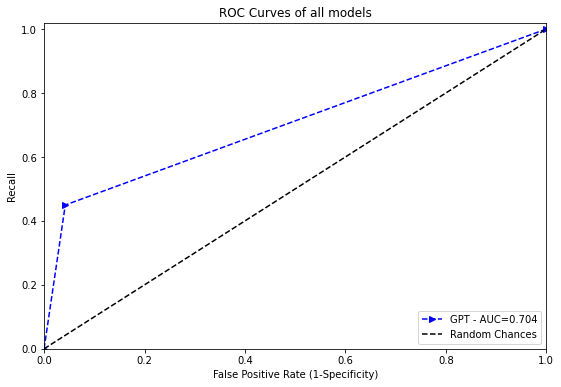

In [ ]:
def graph_multi_ROC (rocs):
  # Set color for each model
  colors = {'LGBM': 'lightcoral','LR': 'darkorange', 'SVM':'lime', 'NB': 'steelblue',
            'XGB': 'purple','DT': 'magenta','RF': 'deeppink','KNN': 'darkturquoise',
            'BERT': 'darkred', 'GPT': 'blue'}
  # Set marker for each model          
  markers = {'LGBM':'1--','LR': 'v--', 'SVM': '^--', 'XGB': '*--', 'DT': 'o--', 'RF': '+--', 'KNN': '.--', 'NB': 'x--', 'BERT':'<--', 'GPT': '>--'}
  
  plt.figure(figsize=(9,6))
  for model in rocs:
    plt.plot( rocs[model]['fpr'], rocs[model]['tpr'], markers[model], color=colors[model], label= model+' - AUC=' + str(rocs[model]['auc'].round(3)) )
  
  plt.plot([0,1], [0,1], 'k--', label='Random Chances')
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.02])
  plt.ylabel('Recall')
  plt.xlabel('False Positive Rate (1-Specificity)')
  plt.legend(loc='lower right') 
  plt.title( 'ROC Curves of all models')
  plt.show()

graph_multi_ROC(rocs)

In [ ]:
# Export performance to a txt file

# Set file name according to Upsampling option
if UPSAMPLE == 1: name = 'GPT_SMOTE'
else: name = 'GPT'

txtfile = open( name + '.txt','w')
txtfile.write(name + '='+ str(rocs['GPT'])+'\n')

txtfile.close()

In [ ]:
rocs

{'GPT': {'accuracy': 0.9100397614314115,
  'auc': 0.7037486903093046,
  'fpr': array([0.        , 0.04223807, 1.        ]),
  'macro-F1': 0.717525982704311,
  'tpr': array([0.        , 0.44973545, 1.        ])}}